In [11]:
#Zadanie 5 
#Uczenie Maszynowe 
#Dominik Kowalczyk

--- KROK 1: Wczytywanie danych z pliku pko_d.csv ---
Znaleziono kolumny: Data='Data', Cena='Zamkniecie'


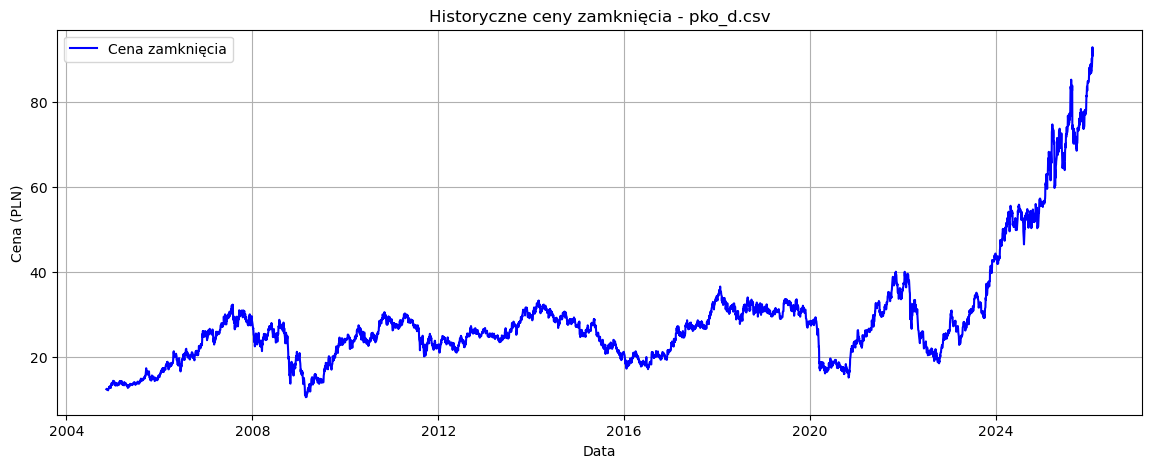

In [12]:
#biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

#wczytanie danych
NAZWA_PLIKU = 'pko_d.csv'  
SEQ_LEN = 60               #długość "pamięci (60 dni wstecz)
PRED_HORIZONS = [1, 5, 20]
EPOCHS = 20                

#sprawdzenie czy plik dobrze się wczytał
print(f"--- KROK 1: Wczytywanie danych z pliku {NAZWA_PLIKU} ---")
try:
    df = pd.read_csv(NAZWA_PLIKU)
except FileNotFoundError:
    print(f"BŁĄD: Nie znaleziono pliku '{NAZWA_PLIKU}'.")
    print("Pobierz go!.")
    exit()

#dane ze stooqa - roznie z nazwa kolumn - ustawiamy tak aby nie mialo to znaczenia 
col_date = 'Data' if 'Data' in df.columns else 'Date'
col_close = 'Zamkniecie' if 'Zamkniecie' in df.columns else 'Close'
print(f"Znaleziono kolumny: Data='{col_date}', Cena='{col_close}'")

#sortowanie chronologiczne (Stooq często daje od najnowszych, a my musimy mieć od najstarszych)
df = df.sort_values(by=col_date, ascending=True)

#wyciągamy tylko ceny zamknięcia
data = df[col_close].values.reshape(-1, 1)

#normalizacja 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#konwersja daty na format datetime
df[col_date] = pd.to_datetime(df[col_date])

plt.figure(figsize=(14, 5))
plt.plot(df[col_date], df[col_close], label='Cena zamknięcia', color='blue')
plt.title(f'Historyczne ceny zamknięcia - {NAZWA_PLIKU}')
plt.xlabel('Data')
plt.ylabel('Cena (PLN)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#tworzenie sekwencji treningowych (X) i etykiet (y)
def create_sequences(dataset, seq_len):
    X, y = [], []
    for i in range(len(dataset) - seq_len):
        X.append(dataset[i:i+seq_len])
        y.append(dataset[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LEN)
train_size = int(len(X) * 0.9)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

#funkcja budowy modelu
def zbuduj_model(typ_komorki="LSTM", liczba_warstw=1, input_shape=(60,1)):
    model = Sequential()
    
    #wybory warstwy
    warstwy_map = {
        "RNN": SimpleRNN,
        "LSTM": LSTM,
        "GRU": GRU
    }
    LayerClass = warstwy_map.get(typ_komorki, LSTM) # Domyślnie LSTM
    
    #budowanie warstw w pętli
    for i in range(liczba_warstw):
        #Sprawdzamy czy to ostatnia warstwa rekurencyjna
        #Jeśli tak -> return_sequences=False (zwraca wektor do Dense)
        #Jeśli nie -> return_sequences=True (zwraca sekwencję do kolejnej warstwy RNN/LSTM)
        is_last_recurrent = (i == liczba_warstw - 1)
        
        konfiguracja = {
            'units': 32,
            'return_sequences': not is_last_recurrent 
        }
        #pierwsza warstwa musi znac input
        if i == 0:
            konfiguracja['input_shape'] = input_shape    
        model.add(LayerClass(**konfiguracja))
        
        #dajmy dropout by uniknąć przeuczenia
        if liczba_warstw > 1:
            model.add(Dropout(0.1))

    model.add(Dense(1))
    
    #mniejszy learning rate dla stabilności przy wielu warstwach
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

typy_sieci = ["RNN", "LSTM", "GRU"]
liczby_warstw = [1, 2, 3]

wyniki_loss = {} #słownik do przechowywania historii uczenia

In [14]:
#trenowanie sieci neuronowych
print(f"Rozpoczynam testowanie {len(typy_sieci) * len(liczby_warstw)} modeli...")
for typ in typy_sieci:
    for warstwy in liczby_warstw:
        nazwa_modelu = f"{typ} ({warstwy} w.)"
        print(f"\n--- Trenowanie: {nazwa_modelu} ---")
        
        model = zbuduj_model(typ, warstwy, input_shape=(SEQ_LEN, 1))
        historia = model.fit(X_train, y_train, 
                             epochs=EPOCHS, 
                             batch_size=32, 
                             validation_data=(X_test, y_test))
        
        #zapisujemy wynik (błąd na zbiorze walidacyjnym)
        wyniki_loss[nazwa_modelu] = historia.history['val_loss']
print("\nTrening zakończony!")

Rozpoczynam testowanie 9 modeli...

--- Trenowanie: RNN (1 w.) ---
Epoch 1/20


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 9.2309e-04 - val_loss: 0.0115
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0829e-04 - val_loss: 0.0062
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1599e-05 - val_loss: 0.0052
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3088e-05 - val_loss: 0.0039
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.1740e-05 - val_loss: 0.0041
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3984e-05 - val_loss: 0.0031
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2126e-05 - val_loss: 0.0034
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1449e-05 - val_loss: 0.0025
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3562e-05 - val_loss: 0.0022
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0806e-05 - val_loss: 0.0020
Epoch 11/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6655e-05 - val_loss: 0.0016
Epoch 12/20
148/

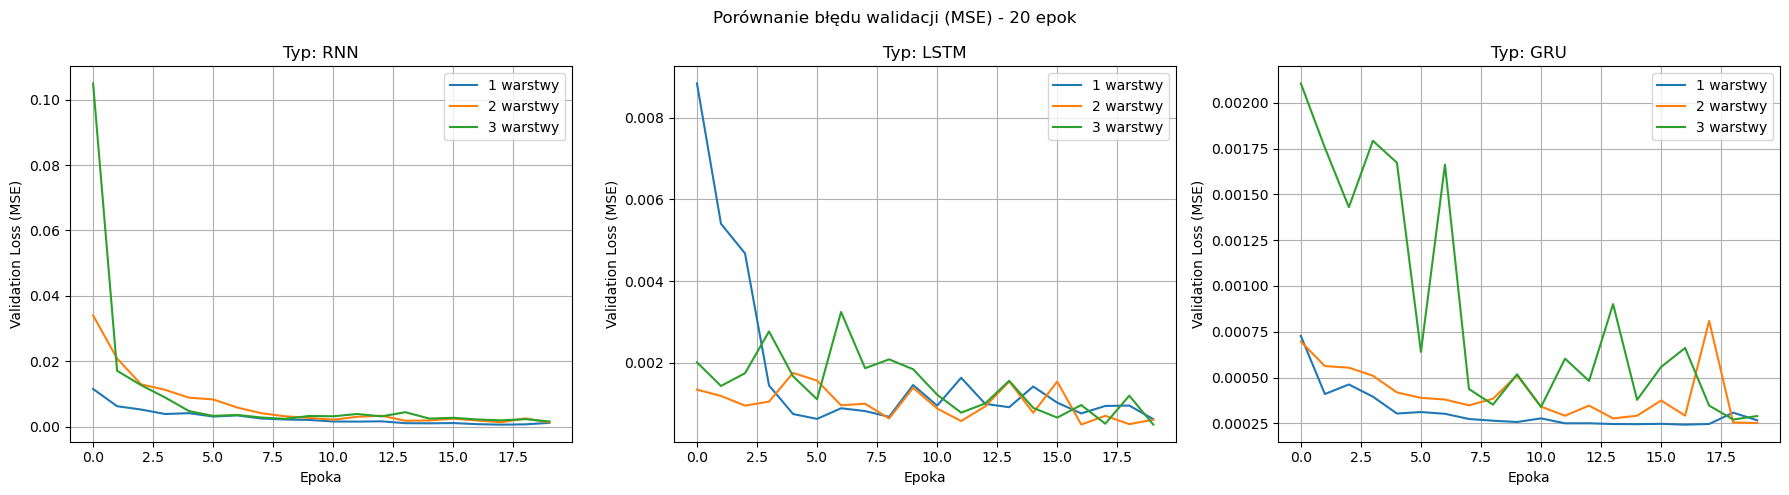

In [15]:
#wykresy porównawcze
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
fig.suptitle(f'Porównanie błędu walidacji (MSE) - {EPOCHS} epok')

for i, typ in enumerate(typy_sieci):
    ax = axes[i]
    ax.set_title(f"Typ: {typ}")
    ax.set_xlabel("Epoka")
    ax.set_ylabel("Validation Loss (MSE)")
    for warstwy in liczby_warstw:
        klucz = f"{typ} ({warstwy} w.)"
        if klucz in wyniki_loss:
            loss_data = wyniki_loss[klucz]
            ax.plot(loss_data, label=f"{warstwy} warstwy")
            
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

SimpleRNN - dla 3 warstwy - problem w prostych sieciach RNN - zwany problemem zanikającego/wybuchającego gradientu.
Choć SimpleRNN charakteryzuje się największym błedem walidacyjnym - jedna warstwa raczej wystarczająca. 

LSTM radzi sobie znacznie lepiej niż RNN. Najlepsza konfiguracja to prawdopodobnie 2 warstwy.

GRU jest najwydajniejszy dla tego problemu. 1 warstwa daje absolutnie najlepszy wynik. Dodawanie kolejnych warstw tylko psuje stabilność.
